In [1]:
from graph import *
from models import *
from metrics import *

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [2]:
# load data from the spreadsheet which defines the structure of the workflow,
# as well as the parameters for data rates, efficiency, data reduction, and classifier performance
# ...these are taken from predictions for the Run-5 CMS
run5_system = dataframes_from_spreadsheet("cms_system_200.xlsx")

In [3]:
run5_system.detectors

,Category,Detector,Data (bytes),Sample Rate,Compression,Link Efficiency (J/bit),Op Efficiency (J/op),PU 200
0,Tracking,Inner Tracker,1440000,40000000,0,2.220000e-11,0,1.440
1,Tracking,Outer Tracker PS,720000,40000000,0,2.220000e-11,0,0.720
2,Tracking,Outer Tracker 2S,430000,40000000,0,2.220000e-11,0,0.430
3,Tracking,Track Finder TPG,10000,40000000,0,2.220000e-11,0,0.010
4,Timing,MIP Timing BTL,240000,40000000,0,2.220000e-11,0,0.240
5,Timing,MIP Timing ETL,440000,40000000,0,2.220000e-11,0,0.440
6,Calorimetry,ECAL Barrel,600000,40000000,0,2.220000e-11,0,0.600
7,Calorimetry,HCAL Barrel,240000,40000000,0,2.220000e-11,0,0.240
8,Calorimetry,HCAL HO,30000,40000000,0,2.220000e-11,0,0.030
9,Calorimetry,HCAL HF,60000,40000000,0,2.220000e-11,0,0.060


In [4]:
run5_system.triggers

,Name,Output,Data (bytes),Reduction Ratio,Classifier,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Tracking,Intermediate,0,1.0,Dummy,0,0,2.500000e-11,0.000,0
1,Timing,Intermediate,0,1.0,Dummy,0,0,2.500000e-11,0.000,0
2,Calorimetry,Intermediate,0,1.0,Dummy,0,0,2.500000e-11,0.000,0
3,Muon,Intermediate,0,1.0,Gaussian,0,0,2.500000e-11,0.000,0
4,Intermediate,Global,260000,53.3,L1T,0,0,2.500000e-11,0.003,0
5,Global,Disk,0,100.0,Gaussian,4,1,2.500000e-11,16.000,0
6,Disk,NaN,0,1.0,Dummy,0,0,2.500000e-11,0.000,0


In [5]:
#calculate the total reduction to keep this constant across experiments
overall_reduction = run5_system.triggers.iloc[4]["Reduction Ratio"] * run5_system.triggers.iloc[5]["Reduction Ratio"]

In [6]:
overall_reduction

5330.0

In [7]:
40e6 / overall_reduction

7504.6904315197

In [8]:
#import the data predicting wall time scaling by pileup
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")
#fit a polynomial to this data for CPU and GPU runtimes
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [9]:
#define a dictionary with functions defining the scaling of trigger runtimes with incoming data
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [10]:
"""
Vary the accept rate of the level 1 trigger and inspect its impact on performance and resources required
"""
def vary_l1t_accept(system: System, functions, reduction: float):
    t = system.triggers.copy()
    #intermediate reduction stage
    t.at[4, "Reduction Ratio"] = reduction
    #global reduction stage
    t.at[5, "Reduction Ratio"] = overall_reduction / reduction
    g = construct_graph(system.detectors, t, system.globals, functions)

    power = g.graph["op power"] + g.graph["link power"]
    confusion = g.graph["performance"]

    return confusion, power, g

In [11]:
#the planned Run-5 L1 accept
ex = vary_l1t_accept(run5_system, funcs, 53.3)

/Users/wilkie/code/system_flow/classifier.py:204: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fit = lambda l: np.abs(self.egamma_rate - quad(lambda x: self.exp_dist(x, l) * interpolator(x), np.min(xs), np.max(xs))[0])


In [12]:
list(ex[2].nodes)

['Inner Tracker',
 'Outer Tracker PS',
 'Outer Tracker 2S',
 'Track Finder TPG',
 'MIP Timing BTL',
 'MIP Timing ETL',
 'ECAL Barrel',
 'HCAL Barrel',
 'HCAL HO',
 'HCAL HF',
 'HGCAL',
 'HGCAL TPG Stage1',
 'HGCAL TPG Stage2',
 'Muon DT',
 'Muon CSC',
 'Muon GEM GE1',
 'Muon GEM GE2',
 'Muon GEM ME0',
 'Muon RPC',
 'Tracking',
 'Timing',
 'Calorimetry',
 'Muon',
 'Intermediate',
 'Global',
 'Disk']

In [13]:
run5_graph = ex[2]

In [14]:
run5_graph.nodes["Intermediate"]["output rate"] / run5_graph.nodes["Tracking"]["output rate"]

0.007592650189816255

In [15]:
run5_graph.nodes["Intermediate"]["reduction"]

0.9812382739212008

In [16]:
run5_graph.nodes["Intermediate"]["output rate"]

303706

In [17]:
run5_graph.nodes["Global"]["input rate"]

303706

In [18]:
run5_graph.nodes["Global"]["output rate"]

3036

In [19]:
run5_graph.nodes["Global"]["reduction"]

0.99

In [20]:
run5_graph.nodes["Global"]["output rate"] / run5_graph.nodes["Intermediate"]["output rate"]

0.00999650978248701

In [21]:
run5_graph.nodes["Global"]["reduction"]

0.99

In [22]:
run5_graph.nodes["Global"]["power"] / 1e6 / 6.8

19.921425882749656

In [23]:
ex[2].graph['op power'] / density_scale_model(ex[2].graph["globals"]["Year"][0]) / 1e6

20.92002782188295

In [24]:
#its predicted confusion matrix for the workflow
ex[0]

array([[39991367,     5592],
       [    1126,     1910]])

In [25]:
#and total required power (MW) using 2024's technology
ex[1] / 1e6

136.09503700869715

In [26]:
#vary this accept rate from today's rate to the planned Run-5 
l1t_reductions = np.linspace(400, 53.3, 101)

In [27]:
hlt_reductions = overall_reduction / l1t_reductions

Text(0, 0.5, 'HLT')

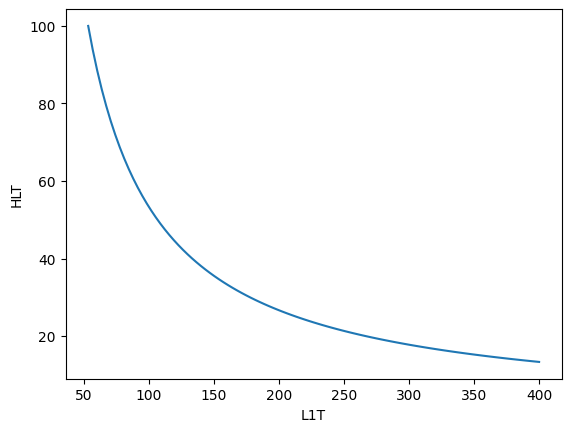

In [28]:
plt.plot(l1t_reductions, hlt_reductions)
plt.xlabel("L1T")
plt.ylabel("HLT")

In [29]:
run5_res = [vary_l1t_accept(run5_system, funcs, r) for r in l1t_reductions]

/Users/wilkie/code/system_flow/classifier.py:204: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fit = lambda l: np.abs(self.egamma_rate - quad(lambda x: self.exp_dist(x, l) * interpolator(x), np.min(xs), np.max(xs))[0])
/Users/wilkie/code/system_flow/classifier.py:204: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probabl

KeyboardInterrupt: 

In [22]:
def extract_metrics(results):
    all_confusion = np.stack([r[0] for r in results])

    all_power = [r[1] / density_scale_model(r[2].graph["globals"]["Year"][0]) for r in results]
    all_power = np.array(all_power)

    all_recall = np.array([recall(all_confusion[i,:,:]) for i in range(all_confusion.shape[0])])
    all_f1 = np.array([f1_score(all_confusion[i,:,:]) for i in range(all_confusion.shape[0])])
    productivity = np.array([np.sum(get_passed(all_confusion[i,:,:])) for i in range(all_confusion.shape[0])])

    metrics = {"confusion": all_confusion,
               "power": all_power,
               "recall": all_recall,
               "f1 score": all_f1,
               "productivity": all_recall * productivity}

    return metrics

In [23]:
run5_metrics = extract_metrics(run5_res)

Text(0.5, 0, 'DAQ Power (MW)')

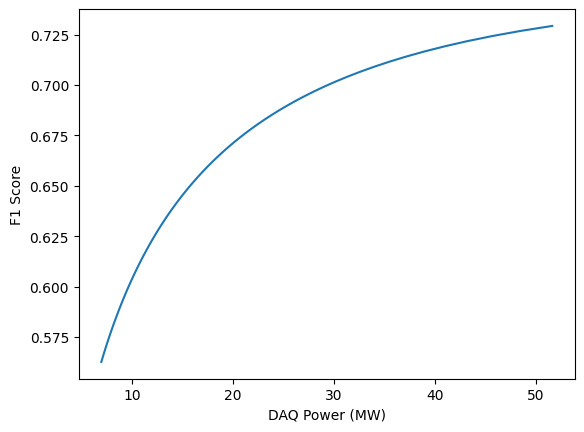

In [24]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["f1 score"])
plt.ylabel("F1 Score")
plt.xlabel("DAQ Power (MW)")

Text(0.5, 0, 'DAQ Power (MW)')

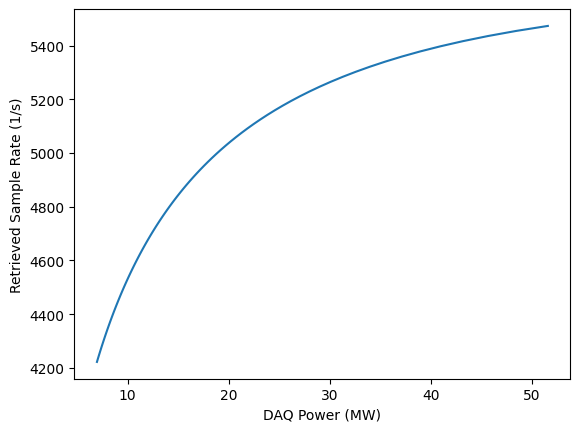

In [25]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"])
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")

In [26]:
#repeat this process for alternative configurations 
# GPU
run5_gpu_res = [vary_l1t_accept(run5_system, funcs_gpu, r) for r in l1t_reductions]
run5_gpu_metrics = extract_metrics(run5_gpu_res)

In [27]:
# Smart pixels & GPU
smartpx_system = dataframes_from_spreadsheet("cms_system_200_smartpx.xlsx")
run5_smartpx_res = [vary_l1t_accept(smartpx_system, funcs_gpu, r) for r in l1t_reductions]
run5_smartpx_metrics = extract_metrics(run5_smartpx_res)

In [28]:
# Smart pixels, GPU, & uLED
smartpx_uled_system = dataframes_from_spreadsheet("cms_system_200_smartpx_uled.xlsx")
run5_smartpx_uled_res = [vary_l1t_accept(smartpx_uled_system, funcs_gpu, r) for r in l1t_reductions]
run5_smartpx_uled_metrics = extract_metrics(run5_smartpx_uled_res)

In [29]:
(40e6 / 53.3 / 100)

7504.6904315197

In [30]:
40e6 / 53.3

750469.04315197

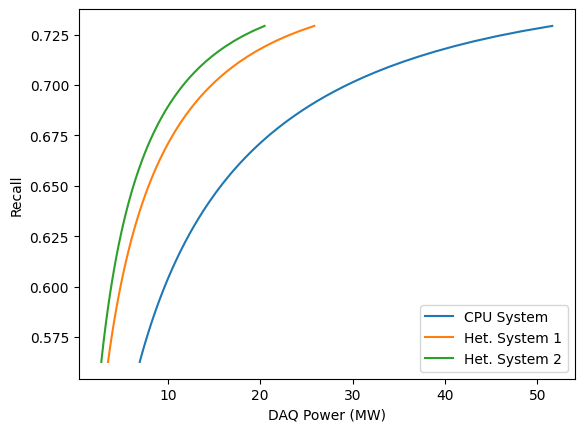

In [31]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["recall"], label = "CPU System")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["recall"], label = "Het. System 1")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["recall"], label = "Het. System 2")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Recall")
plt.xlabel("DAQ Power (MW)")
plt.legend()

In [32]:
import plotly.graph_objects as go

In [33]:
fig = go.Figure()
fig.add_scatter(x = run5_metrics["power"] / 1e6, y = run5_metrics["recall"])
#fig.add_scatter(x = run5_gpu_metrics["power"] / 1e6, y = run5_gpu_metrics["recall"], name = "GPU")
#fig.add_scatter(x = run5_smartpx_metrics["power"] / 1e6, y = run5_smartpx_metrics["recall"], name = "GPU & Smart Pixels")

fig.update_xaxes(range=(0, 60))
fig.update_layout(
    title="Recall vs. Power - Phase-1 DAQ",
    xaxis_title="Total Power (MW)",
    yaxis_title="Recall",
    width = 800,
    height = 600,
)


In [34]:
fig = go.Figure()
fig.add_scatter(x = run5_metrics["power"] / 1e6, y = run5_metrics["recall"], name="CPU")
fig.add_scatter(x = run5_gpu_metrics["power"] / 1e6, y = run5_gpu_metrics["recall"], name = "GPU")
fig.add_scatter(x = run5_smartpx_metrics["power"] / 1e6, y = run5_smartpx_metrics["recall"], name = "GPU & Smart Pixels")

fig.update_xaxes(range=(0, 60))
fig.update_layout(
    title="F1 Score vs. Power",
    xaxis_title="Total Power (MW)",
    yaxis_title="F1 Score",
    legend_title="System",
    width = 800,
    height = 600,
    legend=dict(
        x=0.9,  # x position of the legend (0 corresponds to the left)
        y=0.1,  # y position of the legend (1 corresponds to the top)
        xanchor='right',  # horizontal position anchor ('left', 'center' or 'right')
        yanchor='bottom',  # vertical position anchor ('top', 'middle' or 'bottom')
    )
)


In [35]:
1.0 - run5_gpu_metrics["power"][-4] / run5_gpu_metrics["power"][-1]

0.16266722811259005

In [36]:
run5_gpu_metrics["recall"][-1] - run5_gpu_metrics["recall"][-4]

0.0075587883098301445

In [37]:
bar_results = pd.DataFrame({"name": ["CPU", "GPU", "GPU & Data Reduction"],
                            "power": [run5_metrics["power"][-1], run5_gpu_metrics["power"][-1], run5_smartpx_metrics["power"][-1]],
                            "recall": [run5_metrics["recall"][-1], run5_gpu_metrics["recall"][-1], run5_smartpx_metrics["recall"][-1]]})

In [38]:
fig = go.Figure()

fig.add_bar(x = bar_results["name"], y = bar_results["power"])  # Increase the size and set the font to bold)
fig.update_layout(
    yaxis_title="Total Power (MW)",
    xaxis_title="System",
    title = "Power by System",
    width = 800,
    height = 600,
    title_font = dict(size=36,),
    xaxis=dict(
        title='System',
        titlefont=dict(size=24, family='Arial, bold')  # Bold font for the x-axis title
    ),
    yaxis=dict(
        title='Power Projection (MW)',
        titlefont=dict(size=24, family='Arial, bold')  # Bold font for the y-axis title
    ),
    font = dict(size=18,),
    
)

In [39]:
fig = go.Figure()
fig.add_scatter(x = run5_metrics["power"][-1:] / 1e6, y = run5_metrics["recall"][-1:], name="CPU")
fig.add_scatter(x = run5_gpu_metrics["power"][-1:] / 1e6, y = run5_gpu_metrics["recall"][-1:], name = "GPU")
fig.add_scatter(x = run5_smartpx_metrics["power"][-1:] / 1e6, y = run5_smartpx_metrics["recall"][-1:], name = "GPU & Smart Pixels")

fig.update_xaxes(range=(0, 60))
fig.update_layout(
    title="Recall vs. Power",
    xaxis_title="Total Power (MW)",
    yaxis_title="Recall",
    legend_title="System",
    width = 800,
    height = 600,
)


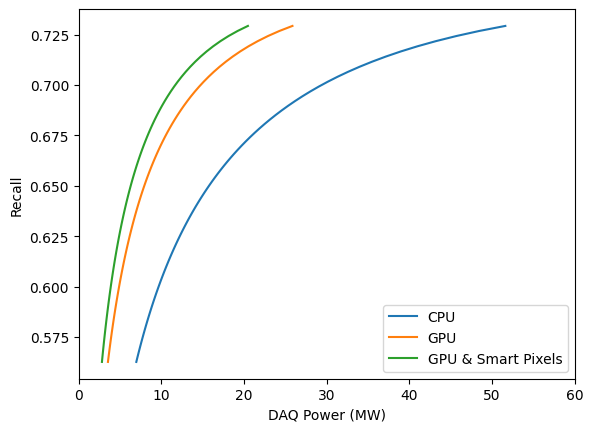

In [40]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["recall"], label = "CPU")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["recall"], label = "GPU")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["recall"], label = "GPU & Smart Pixels")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Recall")
plt.xlabel("DAQ Power (MW)")
plt.xlim(0, 60)
plt.legend()

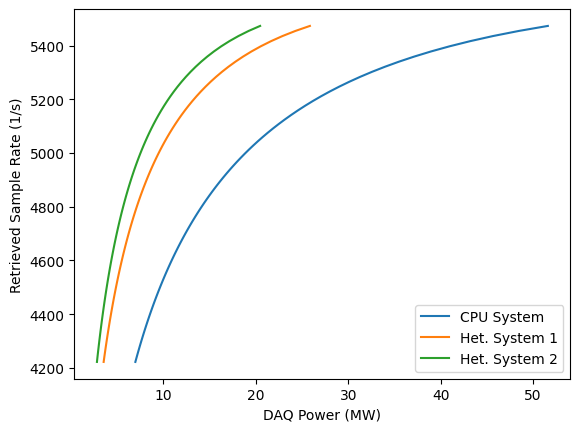

In [41]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"], label = "CPU System")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["productivity"], label = "Het. System 1")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["productivity"], label = "Het. System 2")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")
plt.legend()

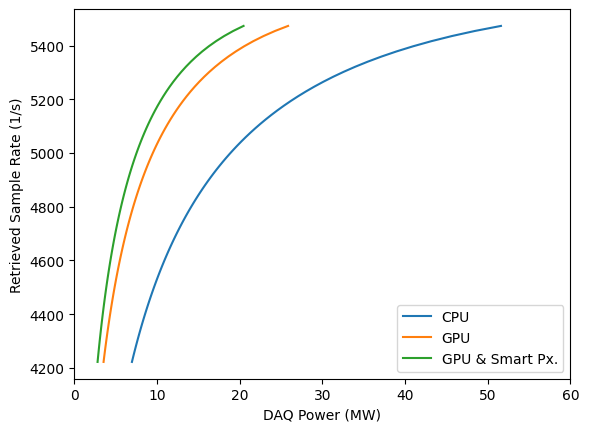

In [42]:
plt.plot(run5_metrics["power"] / 1e6, run5_metrics["productivity"], label = "CPU")
plt.plot(run5_gpu_metrics["power"] / 1e6, run5_gpu_metrics["productivity"], label = "GPU")
plt.plot(run5_smartpx_metrics["power"] / 1e6, run5_smartpx_metrics["productivity"], label = "GPU & Smart Px.")
#plt.plot(run5_smartpx_uled_metrics["power"] / 1e6, run5_smartpx_uled_metrics["recall"], label = "Het. System 3")
plt.ylabel("Retrieved Sample Rate (1/s)")
plt.xlabel("DAQ Power (MW)")
plt.xlim(0, 60)
plt.legend()